In [1]:
import csv as csv
import pandas as pd
import numpy as np
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
import re
import warnings
import seaborn as sns
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 

# 读取评论数据集
df = pd.read_csv('20200105-2u.csv')  #训练集
test_df = pd.read_csv('other20200105u.csv') #测试集

col = ['content', 'label']
df = df[col]

cat=[]
for i in range(len(df['label'])):
    if df['label'][i]==1:
        cat.append('阐述')
    if df['label'][i]==2:
        cat.append('推理')
    if df['label'][i]==3:
        cat.append('判断')
    if df['label'][i]==4:
        cat.append('方法')
df['cat']=cat

cat_label_df = df[['cat','label']].drop_duplicates().sort_values('label').reset_index(drop=True)
cat_to_label = dict(cat_label_df.values)
label_to_cat = dict(cat_label_df[['label', 'cat']].values)

d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)

d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,cat,count
0,阐述,1591
1,推理,608
2,方法,447
3,判断,299


In [2]:
# 提取训练集中的文本内容 
train_sentences = df['content']

# 提取测试集中的文本内容
test_sentences = test_df['content']

# 通过pandas的concat函数将训练集和测试集的文本内容合并到一起
sentences = pd.concat([train_sentences,test_sentences])

# 合并到一起的语料库共有5630行数据
sentences.shape

(3695,)

In [4]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("stop_words.txt")

#删除除字母,数字，汉字以外的所有符号
sentences = sentences.apply(remove_punctuation)

#分词，并过滤停用词
sentences = sentences.map(lambda x: ' '.join(jieba.cut(x))) #以空格分隔jieba分词结果

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\MAC\AppData\Local\Temp\jieba.cache
Loading model cost 1.032 seconds.
Prefix dict has been built succesfully.


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
# features = tfidf.fit_transform(df.content)
features = tfidf.fit_transform(sentences)
labels = df.label
# print(features.shape)
# print('-----------------------------')
# print(features)
# print(tfidf.vocabulary_)

In [42]:
#查看各个标签的样本量
from collections import Counter
Counter(labels)

Counter({2: 608, 3: 299, 4: 447, 1: 1591})

In [43]:
#分词，并过滤停用词
train_sentences = train_sentences.map(lambda x: ' '.join(jieba.cut(x))) #以空格分隔jieba分词结果

In [44]:
#使用imblearn进行随机过采样
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(train_sentences.values.reshape(-1, 1), labels.values)

In [46]:
type(train_sentences)

pandas.core.series.Series

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_sentences,labels,random_state=0,test_size=0.25, stratify=labels)
# X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,random_state=0,test_size=0.25, stratify=y_resampled)

In [40]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

AttributeError: 'list' object has no attribute 'lower'

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
 
#训练模型
model = LinearSVC()
# X_train, X_test, y_train, y_test= train_test_split(features, labels, test_size=0.25, stratify=labels)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(y_test)

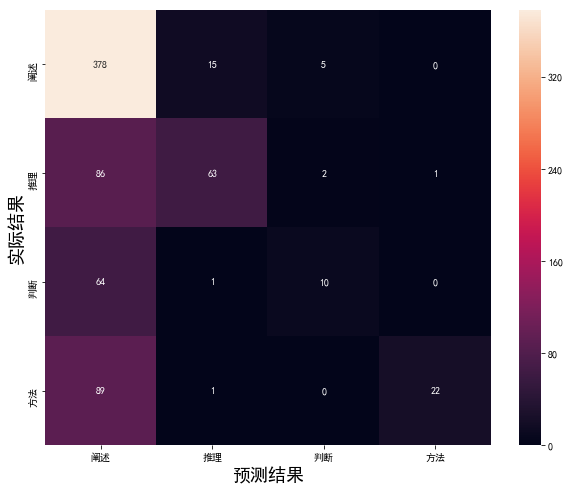

accuracy 0.6417910447761194
             precision    recall  f1-score   support

         阐述       0.61      0.95      0.74       398
         推理       0.79      0.41      0.54       152
         判断       0.59      0.13      0.22        75
         方法       0.96      0.20      0.33       112

avg / total       0.70      0.64      0.59       737



In [64]:
#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_label_df.cat.values, yticklabels=cat_label_df.cat.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)
plt.show()

from sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat_label_df['cat'].values))

In [65]:
# 使用TF-IDF对测试集中的文本进行特征工程
test_X = tfidf.transform(test_sentences)
test_y = model.predict(test_X)
# rs=[]
# for predicted in test_y:
#   rs.append(predicted)
# test_df['predict']=rs
# test_df.to_csv('F:\my_csv7.csv', mode='a', header=True)
# print(0)

In [6]:
from sklearn.datasets import make_classification
from collections import Counter
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
Counter(y)

Counter({2: 4674, 1: 262, 0: 64})

In [10]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X, y)
Counter(y_resampled)

Counter({0: 4060, 1: 4381, 2: 3502})

In [11]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_sample(X, y)
Counter(y_resampled)

Counter({2: 4413, 1: 4566, 0: 4499})